Few key observations
- If both and non-encrypted files are base-32 encoded, accuracy drops really low.
   * Even in this case, fourier analysis (specifically autocorrelation and mean) provide good discrminators
   * Renyi's entropy at alpha=infinity gives good discrimination
   * Overall we see around 13% improvement in F1-score
- Specifically for webpfiles
   * We see that higher moments of around 14 gives a good discrimination
   * Fourier analysis still gives benefits here
- For webpfiles where both unencrypted and encrypted content are base32 encrypted
   * Fourier analysis is still beneficial
- For Non-webp files where plaintext is not base-32 encrypted
   * Accuracy is decent with just the base parameters, but with fourier analysis, we can close to perfect detection


# Contents
- ## [Implementation](#mplementation)
 - ### [List of Files](#list-of-files)
 - ### [Utility to call gc](#gc)
 - ### [Selection of Columns](#select-columns)
 - ### [Function to compare the three selections of columns for a given dataset](#compare-fn)
 - ### [Load the datasets](#load-dataset)
 - ### [Select the datasets](#dataset-selection)
 - ### [Run all combinations of data](#dataset-selection)
- ## [Results](#results)
 - ### [Print the raw results](#raw-results)
 - ### [Sort by the improvement when using Fourier transforms over baseline](#sorted-fourier)
 - ### [Measure improvement when only webp files are used](#webp-only)
 - ### [Measure improvement when webp files are not present](#no-webp)
 - ### [Measure improvement for balanced datasets](#balanced-dataset)
 - ### [Measure the improvement when all files are used](#full-dataset)
 - ### [Focus on items where the base metrics performed well](#focus-greater-90)
 - ### [Correlation of data set and performance]("corr-heatmap")
 - ### [Average out all the metrics](#mean-fscores)
 


## Implementation <a class="anchor" id="implementation">
    
[top](#Contents)

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats

from functools import lru_cache

import gc

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, accuracy_score, recall_score

import matplotlib.pyplot as plt
import glob

import tqdm
from multiprocessing.pool import ThreadPool, Pool

plt.rcParams["figure.figsize"] = (20,20)

### List of files <a class="anchor" id="list-of-files">

[top](#Contents)

In [2]:
!ls

LR_CS5_DES3.ipynb                     gd.sampled.encrypted.v2.base32.csv.gz
RF_CS5_DES3.ipynb                     gd.sampled.encrypted.v2.csv.gz
gd.sampled.encrypted.v1.base32.csv.gz gd.sampled.pt.base32.csv.gz
gd.sampled.encrypted.v1.csv.gz        gd.sampled.pt.csv.gz


### Utility to call GC <a class="anchor" id="gc">
    
[top](#Contents)

In [3]:
def call_gc():
    for i in range(3):
        for j in range(3):
            gc.collect(j)

### Selection of columns <a class="anchor" id="select-columns">
    
This function is used to select the columns.
There are three different configurations:
    
    1. Baseline - statistics like autocorrelation, shannon entropy, chi-square etc. are used
    
    2. Advanced - More statistics like moments, Tsallis and Renyi entropy, higher moments etc.
    
    3. Fourier - Some statistics of the Fourier Power Spectrum distribution
    
[top](#Contents)

In [4]:
def get_columns(thisdf):
    baseline_columns = [c for c in thisdf.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
    baseline_columns = [c for c in baseline_columns if "filesize" not in c]
    baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

    advanced_columns = [c for c in thisdf.columns if "advanced" in c]
    advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
    advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
    advanced_columns = [c for c in advanced_columns if "start" not in c]
    advanced_columns_only = list(set(advanced_columns))
    advanced_columns = list(set(advanced_columns + baseline_columns))

    fourier_columns = [c for c in thisdf.columns if "fourier" in c and "value" not in c]
    fourier_columns = [c for c in fourier_columns if "1byte" in c]
    fourier_columns = [c for c in fourier_columns if "begin" not in c and "end" not in c]
    fourier_columns = [c for c in fourier_columns if "head" not in c and "tail" not in c]
    fourier_columns = [c for c in fourier_columns if "start" not in c]
    fourier_columns_only = list(set(fourier_columns))
    fourier_columns = list(set(advanced_columns + fourier_columns))
    
    baseline_and_advanced = list(set(baseline_columns + advanced_columns_only))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns_only))
    advanced_and_fourier = list(set(advanced_columns_only + fourier_columns_only))
    
    return {\
        "baseline": baseline_columns,\
        "advanced-only": advanced_columns_only,\
        "fourier-only": fourier_columns_only,\
        "baseline-and-fourier": baseline_and_fourier,\
        "advanced-and-fourier": advanced_and_fourier,\
        "advanced": advanced_columns,\
        "fourier": fourier_columns,\
    }

### Function to compare the three selections of columns for a given dataset <a class="anchor" id="compare-fn">
    
For the three different sets of measurements described above, compare all the three sets for their f1 score
    
[top](#Contents)

In [5]:
USE_ASYNC = False
N_SPLITS=5

def get_kfold_f1_score(name, collist, X, y):
    skf = StratifiedKFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    X = X[collist].to_numpy()
    y = y.to_numpy()
    call_gc()
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        rfc = RandomForestClassifier(n_jobs=10, random_state=42)
        estimators = [\
                      ('std,', MinMaxScaler()), \
                      ('RandomForestClassifier', rfc)]
        pipeline = Pipeline(estimators)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
        accuracy_scores.append(accuracy_score(y_test, y_pred))

    return name, \
            float(np.mean(f1_scores)),\
            float(np.mean(accuracy_scores)),\
            float(np.mean(precision_scores)),\
            float(np.mean(recall_scores)),

def compare_feature_selections_async(X, y):
    columns_dict = get_columns(X)
    ret = dict()
    pool = Pool(3)
    async_results = list()
    for name, collist in columns_dict.items():
        result = pool.apply_async(\
                                  get_kfold_f1_score, \
                                  (name, collist, X, y))
    for result in async_results:
        name, f1 = result.get(timeout=None)
        ret[name] = f1
    return ret

def compare_feature_selections_sync(X, y):
    columns_dict = get_columns(X)
    ret = dict()
    for name, collist in columns_dict.items():
        name, f1, accuracy, precision, recall = \
            get_kfold_f1_score(name, collist, X, y)
        ret[f"{name}-f1_score"] = f1
        ret[f"{name}-accuracy_score"] = accuracy
        ret[f"{name}-precision_score"] = precision
        ret[f"{name}-recall_score"] = recall
    return ret

def compare_feature_selections(X, y):
    if USE_ASYNC:
        return compare_feature_selections_async(X, y)
    else:
        return compare_feature_selections_sync(X, y)

def compare_feature_selections_wrapper(data):
    X = data[[c for c in data.columns if "is_encrypted" != c]]
    y = data["is_encrypted"]
    return compare_feature_selections(X, y)


### Load the datasets <a class="anchor" id="load-dataset">

We don't want to load the datasets again and again, so we load them once.
The LRU cache ensures that the next time this is called, we don't load the datasets again.
    
[top](#Contents)

In [6]:
@lru_cache
def load_datasets_once():
    """Load all datasets only once
    
    We want to load the datasets only once. Once loaded
    serve from cache
    """
    datasets = dict()
    for file in glob.glob("*.csv.gz"):
        df = pd.read_csv(file)
        df = df.sample(frac=1).reset_index(drop=True)
        df["is_encrypted"] = 1 if "encr" in file.lower() else 0
        datasets[file] = df
    return datasets

### Select the datasets <a class="anchor" id="dataset-selection">

Select the dataset, combine it, shuffle it and return
    
We used several schemes:
* Plaintext
  - The base plaintext dataset of around 50k files
  - Expanded dataset, where all files that were less than 1500 bytes were expanded by repeating the file
  - Base32 encoding of
   - original plaintext
   - expanded plaintext
* Encryption : We used two schemes for encruption
  - v1 : AES 256 encryption of the full file, again two varieties were used
    - Plain encryption
    - Encryption followed by base32 encoding
  - v2 : AES encryption of the file, the first and the last 128 bytes are not encrypted. Of the remaining file, every alternate 16 bytes are encrypted.
    - Plain encryption
    - encryption followed by base32 encoding
    
We select combinations of the above datasets
    
Furthermore, we add further combinations by including and excluding webp files, and including and excluding non-webp files.
    
[top](#Contents)

In [7]:
def get_dataset(\
               exclude_plaintext_nonbase32=False,
               exclude_plaintext_base32=False,
               exclude_encrypted_v1=False,
               exclude_encrypted_v2=False,
               exclude_encrypted_base32=False,
               exclude_encrypted_nonbase32=False,
               exclude_webp=False,
               exclude_nonwebp=False):
    description = {k:v for k,v in locals().items() \
                   if "exclude" in k}
    
    files = glob.glob("*.csv.gz")
    
    
    if exclude_plaintext_nonbase32:
        files = [f for f in files if \
                     "plaintext" not in f \
                     or "_base32" in f \
                     or "_b32" in f]
    if exclude_plaintext_base32:
        files = [f for f in files if\
                    "plaintext" not in f or \
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_v1:
        files = [f for f in files if\
                    "_v1" not in f or "encr" not in f]
    if exclude_encrypted_v2:
        files = [f for f in files if \
                    "_v2" not in f or "encr" not in f]
    if exclude_encrypted_base32:
        files = [ f for f in files if\
                    "encr" not in f or\
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_nonbase32:
        files = [f for f in files if \
                    "encr" not in f or \
                    "base32" in f or "b32" in f]
        
        
    encrypted_count = len([f for f in files if "encr" in f])
    non_encrypted_count = len([f for f in files if "encr" not in f])
    
    if 0 == encrypted_count or 0 == non_encrypted_count or 0 == len(files):
        return description, None, -1, -1
    
    all_dfs = list()
    all_loaded_datasets = load_datasets_once()
    for filename in files:
        all_dfs.append(all_loaded_datasets[filename])
    
    combined_df = pd.concat(all_dfs)
    
    if exclude_webp:
        combined_df = combined_df[\
                        combined_df["extended.extension"] != ".webp"]
    if exclude_nonwebp:
        combined_df = combined_df[\
                        combined_df["extended.extension"] == ".webp"]
        
    if len(combined_df) == 0:
        return description, None, -1, -1
    
        
    encrypt_count = len(combined_df[combined_df["is_encrypted"] == 1])
    nonencrypted_count = len(combined_df[combined_df["is_encrypted"] == 0])

    
    if 0 == len(combined_df) or 0 == encrypt_count or 0 == nonencrypted_count:
        return description, None, -1, -1
    
    return description, combined_df, encrypt_count, nonencrypted_count

### Run all combinations of data <a class="anchor" id="dataset-selection">

For all combinations of the datasets, compare the three classes (basic, advanced, and Fourier)
    
[top](#Contents)

In [8]:
all_results = []
list_of_arguments = []

# Get all 8-tuple combinations of T/F
list_of_arguments = [(True,), (False,)]
for i in range(7):
    temp = []
    for e in list_of_arguments:
        et = e + (True,)
        temp.append(et)
        et = e + (False,)
        temp.append(et)
    list_of_arguments = temp

     
for a, b, c, k, e, f, g, h in tqdm.tqdm(list_of_arguments):
    desc, df, ec, nec = get_dataset(a, b, c, k, e, f, g, h)
    if df is not None:
        result = compare_feature_selections_wrapper(df)
        call_gc()
        result = {**desc, **result}
        result["n_encrypted"] = ec
        result["n_non_encrypted"] = nec
        result["ratio_encrypt_nonencrypt"] = float(ec) / nec
        all_results.append(result)


df_dict = {k:[] for k in all_results[0]}
for result in all_results:
    for k, v in result.items():
        df_dict[k].append(v)

df = pd.DataFrame(df_dict)
df["best_f1_score"] = \
    df[[c for c in df.columns if "f1_score" in c]].max(axis=1)

df["improvement_in_advanced"] = \
    df["advanced-f1_score"] - df["baseline-f1_score"]
df["improvement_in_fourier"] = \
    df["fourier-f1_score"] - df["baseline-f1_score"]
df = df.sort_values(by="improvement_in_fourier", ascending=False)                        

100%|████████████████████████████████████████████████| 256/256 [19:38:46<00:00, 276.27s/it]


## Results <a class="anchor" id="results">
    
In this section, we present the results
    
[top](#Contents)

### Print the raw results <a class="anchor" id="raw-results">
    
[top](#Contents)

In [49]:
pd.set_option('display.max_columns', None)
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143
Unnamed: 0,10,19,64,136,37,127,46,109,118,100,55,91,28,82,73,1,117,18,27,9,72,36,135,126,90,108,99,81,0,63,45,54,20,11,38,2,137,65,128,56,110,101,119,74,83,92,47,29,132,51,78,114,42,15,69,60,105,141,87,33,24,6,96,123,79,52,34,97,124,61,106,16,70,142,25,133,115,7,88,43,75,129,3,57,120,21,39,66,111,84,138,30,12,102,93,48,71,35,26,80,62,53,17,44,89,143,134,125,107,116,8,98,59,14,113,77,95,104,86,68,122,32,140,23,131,50,41,5,67,103,58,22,4,76,130,13,49,121,40,94,139,31,85,112
exclude_plaintext_nonbase32,True,True,True,False,True,False,True,False,False,False,True,False,True,False,False,True,False,True,True,True,False,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,False,True,False,True,False,False,False,False,False,False,True,True,False,True,False,False,True,True,True,True,False,False,False,True,True,True,False,False,False,True,True,False,False,True,False,True,True,False,True,False,False,True,False,True,False,False,True,True,False,True,True,True,False,False,False,True,True,False,False,True,True,True,True,False,True,True,True,True,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,True,False,True,False,True,False,True,True,True,True,False,True,True,True,False,False,True,True,False,True,False,False,True,False,False
exclude_plaintext_base32,True,True,False,False,False,False,False,False,False,True,False,True,True,True,True,True,False,True,True,True,True,False,False,False,True,False,True,True,True,False,False,False,True,True,False,True,False,False,False,False,False,True,False,True,True,True,False,True,False,False,True,False,False,True,False,False,True,False,True,True,True,True,True,False,True,False,True,True,False,False,True,True,False,False,True,False,False,True,True,False,True,False,True,False,False,True,False,False,False,True,False,True,True,True,True,False,False,True,True,True,False,False,True,False,True,False,False,False,True,False,True,True,False,True,False,True,True,True,True,False,False,True,False,True,False,False,False,True,False,True,False,True,True,True,False,True,False,False,False,True,False,True,True,False
exclude_encrypted_v1,True,False,False,False,True,False,True,True,True,False,False,False,False,True,True,True,True,False,False,True,True,True,False,False,False,True,False,True,True,False,True,False,False,True,True,True,False,False,False,False,True,False,True,True,True,False,True,False,False,True,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,False,False,True,False,False,True,False,False,False,False,True,True,True,True,True,False,True,False,True,False,True,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,True,True,True,False,False,True,False,True,True,False,False,True,True,True,False,False,True,False,True,False,False,False,False,True,True,True,False,False,False,False,True,True,False,True,True,True,True,False,False,False,True,True
exclude_encrypted_v2,False,True,False,False,True,True,False,True,False,False,True,True,False,False,True,True,False,True,False,False,True,True,False,True,True,True,False,False,True,False,False,True,True,False,True,True,False,False,True,True,True,False,False,True,False,True,False,False,True,False,True,True,True,False,False,True,False,False,False,False,True,True,True,False,True,False,False,True,False,True,False,False,False,False,True,True,True,True,False,True,True,True,True,True,False,True,True,False,True,False,False,False,False,False,True,False,False,False,True,True,True,False,False,True,False,False,T

In [50]:
df.to_csv("../RF_comparison.csv")

In [51]:
df = df.sort_values(by="improvement_in_fourier", ascending=False)

### Sort by the improvement when using Fourier transforms over baseline <a class="anchor" id="sorted-fourier">

We also take a few other things:
* Room for improvement (1 - baseline score)
* How much of the room for improvement was filled by fourier transforms (percentage)
* Difference between F1 score with advanced and fourier
        
[top](#Contents)

In [52]:
df["improvement_in_advanced"] = \
    df["advanced-f1_score"] - df["baseline-f1_score"]
df["room_for_improvement"] = \
    1.0 - df["baseline-f1_score"]
df["fourier_minus_advanced"] = \
    df["fourier-f1_score"] - df["advanced-f1_score"]
df["percentage_of_room_filled"] = \
    df["improvement_in_fourier"] * 100.0 / df["room_for_improvement"]
#df.sort_values(by="fourier_minus_advanced", ascending=False)
df.T

,0,9,1,15,14,13,11,10,12,8,7,6,5,4,3,2,24,31,30,29,28,27,26,25,20,23,22,21,19,18,17,16,40,47,46,45,44,43,42,41,35,39,38,37,36,34,33,32,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,79,78,77,76,75,74,73,72,71,69,68,67,66,65,64,70,88,95,94,93,92,91,90,89,87,86,85,84,83,82,81,80,104,111,110,109,107,106,105,108,103,101,100,99,98,97,96,102,120,127,126,125,123,122,121,124,119,117,116,115,114,113,112,118,136,142,141,140,139,138,137,132,135,134,133,131,130,129,128,143
Unnamed: 0,10,100,19,1,73,82,91,55,28,118,109,46,127,37,136,64,90,54,45,63,0,81,99,108,72,126,135,36,9,27,18,117,110,29,47,92,83,74,119,101,2,56,128,65,137,38,11,20,123,96,6,24,33,87,141,105,60,69,15,42,114,78,51,132,43,88,7,115,133,25,142,70,16,61,124,97,34,52,79,106,111,48,93,102,12,30,138,84,66,39,21,120,57,3,129,75,89,98,8,116,125,134,143,107,44,53,62,80,26,35,71,17,122,5,41,50,23,140,32,131,68,104,95,77,113,14,59,86,49,85,31,139,94,40,121,4,13,130,76,22,58,103,67,112
exclude_plaintext_nonbase32,True,False,True,True,False,False,False,True,True,False,False,True,False,True,False,True,False,True,True,True,True,False,False,False,False,False,False,True,True,True,True,False,False,True,True,False,False,False,False,False,True,True,False,True,False,True,True,True,False,False,True,True,True,False,False,False,True,True,True,True,False,False,True,False,True,False,True,False,False,True,False,True,True,True,False,False,True,True,False,False,False,True,False,False,True,True,False,False,True,True,True,False,True,True,False,False,False,False,True,False,False,False,False,False,True,True,True,False,True,True,True,True,False,True,True,True,True,False,True,False,True,False,False,False,False,True,True,False,True,False,True,False,False,True,False,True,True,False,False,True,True,False,True,False
exclude_plaintext_base32,True,True,True,True,True,True,True,False,True,False,False,False,False,False,False,False,True,False,False,False,True,True,True,False,True,False,False,False,True,True,True,False,False,True,False,True,True,True,False,True,True,False,False,False,False,False,True,True,False,True,True,True,True,True,False,True,False,False,True,False,False,True,False,False,False,True,True,False,False,True,False,False,True,False,False,True,True,False,True,True,False,False,True,True,True,True,False,True,False,False,True,False,False,True,False,True,True,True,True,False,False,False,False,True,False,False,False,True,True,True,False,True,False,True,False,False,True,False,True,False,False,True,True,True,False,True,False,True,False,True,True,False,True,False,False,True,True,False,True,True,False,True,False,False
exclude_encrypted_v1,True,False,False,True,True,True,False,False,False,True,True,True,False,True,False,False,False,False,True,False,True,True,False,True,True,False,False,True,True,False,False,True,True,False,True,False,True,True,True,False,True,False,False,False,False,True,True,False,True,False,True,False,False,True,False,False,False,False,True,True,True,True,True,False,True,True,True,True,False,False,False,False,True,False,True,False,False,True,True,False,True,True,False,False,True,False,False,True,False,True,False,True,False,True,False,True,True,False,True,True,True,False,False,False,True,True,False,True,False,False,False,True,True,True,True,True,False,False,False,False,False,False,False,True,True,True,False,True,True,True,False,False,False,True,True,True,True,False,True,False,False,False,False,True
exclude_encrypted_v2,False,False,True,True,True,False,True,True,False,False,True,False,True,True,False,False,True,True,False,False,True,False,False,True,True,True,False,True,False,False,True,False,True,False,False,True,False,True,False,False,True,True,True,False,False,True,False,True,False,True,True,True,False,False,False,False,True,False,False,True,True,True,False,True,True,False,True,True,True,True,False,False,False,True,False,True,False,False,True,False,True,False,True,False,False,False,False,False,False,True,True,False,True,True,True,True,False,True,True,True,False,True,False,False,True,False,Tr

### Measure improvement when only webp files are used <a class="anchor" id="webp-only">

We want to measure this alone because in the literature, poor performance in webp files has been mentioned
    
[top](#Contents)

In [53]:
df[(df["exclude_webp"] == False) & \
   (df["exclude_nonwebp"] == True)].T

,0,9,1,15,14,13,11,10,12,8,7,6,5,4,3,2,79,78,77,76,75,74,73,72,71,69,68,67,66,65,64,70,136,142,141,140,139,138,137,132,135,134,133,131,130,129,128,143
Unnamed: 0,10,100,19,1,73,82,91,55,28,118,109,46,127,37,136,64,43,88,7,115,133,25,142,70,16,61,124,97,34,52,79,106,49,85,31,139,94,40,121,4,13,130,76,22,58,103,67,112
exclude_plaintext_nonbase32,True,False,True,True,False,False,False,True,True,False,False,True,False,True,False,True,True,False,True,False,False,True,False,True,True,True,False,False,True,True,False,False,True,False,True,False,False,True,False,True,True,False,False,True,True,False,True,False
exclude_plaintext_base32,True,True,True,True,True,True,True,False,True,False,False,False,False,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,True,False,True,True,False,True,True,False,True,False,False,True,True,False,True,True,False,True,False,False
exclude_encrypted_v1,True,False,False,True,True,True,False,False,False,True,True,True,False,True,False,False,True,True,True,True,False,False,False,False,True,False,True,False,False,True,True,False,True,True,False,False,False,True,True,True,True,False,True,False,False,False,False,True
exclude_encrypted_v2,False,False,True,True,True,False,True,True,False,False,True,False,True,True,False,False,True,False,True,True,True,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,True,False,True,False,True,True,True,True,False,False,True
exclude_encrypted_base32,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
exclude_encrypted_nonbase32,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
exclude_webp,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
exclude_nonwebp,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
baseline-f1_score,0.796234,0.796234,0.796234,0.796234,0.796234,0.796234,0.796234,0.796234,0.796234,0.796234,0.796234,0.796234,0.796234,0.796234,0.796234,0.796234,0.80315,0.80315,0.80315,0.80315,0.80315,0.80315,0.80315,0.80315,0.80315,0.80315,0.80315,0.80315,0.80315,0.80315,0.80315,0.80315,0.808721,0.808721,0.808721,0.808721,0.808721,0.808721,0.808721,0.808721,0.808721,0.808721,0.808721,0.808721,0.808721,0.808721,0.808721,0.808721


### Measure improvement when webp files are not present <a class="anchor" id="no-webp">
    
[top](#Contents)

In [54]:
df[(df["exclude_webp"] == True) & \
   (df["exclude_nonwebp"] == False)].T

,24,31,30,29,28,27,26,25,20,23,22,21,19,18,17,16,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,88,95,94,93,92,91,90,89,87,86,85,84,83,82,81,80
Unnamed: 0,90,54,45,63,0,81,99,108,72,126,135,36,9,27,18,117,123,96,6,24,33,87,141,105,60,69,15,42,114,78,51,132,111,48,93,102,12,30,138,84,66,39,21,120,57,3,129,75
exclude_plaintext_nonbase32,False,True,True,True,True,False,False,False,False,False,False,True,True,True,True,False,False,False,True,True,True,False,False,False,True,True,True,True,False,False,True,False,False,True,False,False,True,True,False,False,True,True,True,False,True,True,False,False
exclude_plaintext_base32,True,False,False,False,True,True,True,False,True,False,False,False,True,True,True,False,False,True,True,True,True,True,False,True,False,False,True,False,False,True,False,False,False,False,True,True,True,True,False,True,False,False,True,False,False,True,False,True
exclude_encrypted_v1,False,False,True,False,True,True,False,True,True,False,False,True,True,False,False,True,True,False,True,False,False,True,False,False,False,False,True,True,True,True,True,False,True,True,False,False,True,False,False,True,False,True,False,True,False,True,False,True
exclude_encrypted_v2,True,True,False,False,True,False,False,True,True,True,False,True,False,False,True,False,False,True,True,True,False,False,False,False,True,False,False,True,True,True,False,True,True,False,True,False,False,False,False,False,False,True,True,False,True,True,True,True
exclude_encrypted_base32,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
exclude_encrypted_nonbase32,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
exclude_webp,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
exclude_nonwebp,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
baseline-f1_score,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332


In [55]:
df[(df["exclude_webp"] == True) & \
   (df["exclude_nonwebp"] == False)].T


,24,31,30,29,28,27,26,25,20,23,22,21,19,18,17,16,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,88,95,94,93,92,91,90,89,87,86,85,84,83,82,81,80
Unnamed: 0,90,54,45,63,0,81,99,108,72,126,135,36,9,27,18,117,123,96,6,24,33,87,141,105,60,69,15,42,114,78,51,132,111,48,93,102,12,30,138,84,66,39,21,120,57,3,129,75
exclude_plaintext_nonbase32,False,True,True,True,True,False,False,False,False,False,False,True,True,True,True,False,False,False,True,True,True,False,False,False,True,True,True,True,False,False,True,False,False,True,False,False,True,True,False,False,True,True,True,False,True,True,False,False
exclude_plaintext_base32,True,False,False,False,True,True,True,False,True,False,False,False,True,True,True,False,False,True,True,True,True,True,False,True,False,False,True,False,False,True,False,False,False,False,True,True,True,True,False,True,False,False,True,False,False,True,False,True
exclude_encrypted_v1,False,False,True,False,True,True,False,True,True,False,False,True,True,False,False,True,True,False,True,False,False,True,False,False,False,False,True,True,True,True,True,False,True,True,False,False,True,False,False,True,False,True,False,True,False,True,False,True
exclude_encrypted_v2,True,True,False,False,True,False,False,True,True,True,False,True,False,False,True,False,False,True,True,True,False,False,False,False,True,False,False,True,True,True,False,True,True,False,True,False,False,False,False,False,False,True,True,False,True,True,True,True
exclude_encrypted_base32,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
exclude_encrypted_nonbase32,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
exclude_webp,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
exclude_nonwebp,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
baseline-f1_score,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332


### Measure improvement for balanced datasets <a class="anchor" id="balanced-dataset">

Most of our dataset selections are not balanced, and we didn't do anything to mitigate
unablanced datasets. This is because we are measuring the baseline and improvement on the
same dataset.
    
However, we will select those instances where the datasets were balanced to see if the
improvement is still significant in these instances.
    
[top](#Contents)

In [56]:
df[(df["ratio_encrypt_nonencrypt"] > 0.9) & (df["ratio_encrypt_nonencrypt"] < 1.1)].T

,0,9,1,15,14,13,11,10,12,8,7,6,5,4,3,2,24,31,30,29,28,27,26,25,20,23,22,21,19,18,17,16,40,47,46,45,44,43,42,41,35,39,38,37,36,34,33,32,88,95,94,93,92,91,90,89,87,86,85,84,83,82,81,80,120,127,126,125,123,122,121,124,119,117,116,115,114,113,112,118,136,142,141,140,139,138,137,132,135,134,133,131,130,129,128,143
Unnamed: 0,10,100,19,1,73,82,91,55,28,118,109,46,127,37,136,64,90,54,45,63,0,81,99,108,72,126,135,36,9,27,18,117,110,29,47,92,83,74,119,101,2,56,128,65,137,38,11,20,111,48,93,102,12,30,138,84,66,39,21,120,57,3,129,75,122,5,41,50,23,140,32,131,68,104,95,77,113,14,59,86,49,85,31,139,94,40,121,4,13,130,76,22,58,103,67,112
exclude_plaintext_nonbase32,True,False,True,True,False,False,False,True,True,False,False,True,False,True,False,True,False,True,True,True,True,False,False,False,False,False,False,True,True,True,True,False,False,True,True,False,False,False,False,False,True,True,False,True,False,True,True,True,False,True,False,False,True,True,False,False,True,True,True,False,True,True,False,False,False,True,True,True,True,False,True,False,True,False,False,False,False,True,True,False,True,False,True,False,False,True,False,True,True,False,False,True,True,False,True,False
exclude_plaintext_base32,True,True,True,True,True,True,True,False,True,False,False,False,False,False,False,False,True,False,False,False,True,True,True,False,True,False,False,False,True,True,True,False,False,True,False,True,True,True,False,True,True,False,False,False,False,False,True,True,False,False,True,True,True,True,False,True,False,False,True,False,False,True,False,True,False,True,False,False,True,False,True,False,False,True,True,True,False,True,False,True,False,True,True,False,True,False,False,True,True,False,True,True,False,True,False,False
exclude_encrypted_v1,True,False,False,True,True,True,False,False,False,True,True,True,False,True,False,False,False,False,True,False,True,True,False,True,True,False,False,True,True,False,False,True,True,False,True,False,True,True,True,False,True,False,False,False,False,True,True,False,True,True,False,False,True,False,False,True,False,True,False,True,False,True,False,True,True,True,True,True,False,False,False,False,False,False,False,True,True,True,False,True,True,True,False,False,False,True,True,True,True,False,True,False,False,False,False,True
exclude_encrypted_v2,False,False,True,True,True,False,True,True,False,False,True,False,True,True,False,False,True,True,False,False,True,False,False,True,True,True,False,True,False,False,True,False,True,False,False,True,False,True,False,False,True,True,True,False,False,True,False,True,True,False,True,False,False,False,False,False,False,True,True,False,True,True,True,True,False,True,True,False,True,False,False,True,False,False,True,True,True,False,True,False,False,False,False,False,True,True,False,True,False,True,True,True,True,False,False,True
exclude_encrypted_base32,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
exclude_encrypted_nonbase32,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
exclude_webp,False,False,False,False,False,False,Fal

### Measure the improvement when all files are used <a class="anchor" id="full-dataset">

In most of our dataset selections, we excluded some data points based on our criteria.

In this, we measure the improvement when we use all data points
    
[top](#Contents)

In [59]:
# Measure everything for the full dataset
df2 = df
for colname in df2.columns:
    if "exclude" in colname:
        df2 = df2[df2[colname] == False]
df2

,Unnamed: 0,exclude_plaintext_nonbase32,exclude_plaintext_base32,exclude_encrypted_v1,exclude_encrypted_v2,exclude_encrypted_base32,exclude_encrypted_nonbase32,exclude_webp,exclude_nonwebp,baseline-f1_score,baseline-accuracy_score,baseline-precision_score,baseline-recall_score,advanced-only-f1_score,advanced-only-accuracy_score,advanced-only-precision_score,advanced-only-recall_score,fourier-only-f1_score,fourier-only-accuracy_score,fourier-only-precision_score,fourier-only-recall_score,baseline-and-fourier-f1_score,baseline-and-fourier-accuracy_score,baseline-and-fourier-precision_score,baseline-and-fourier-recall_score,advanced-and-fourier-f1_score,advanced-and-fourier-accuracy_score,advanced-and-fourier-precision_score,advanced-and-fourier-recall_score,advanced-f1_score,advanced-accuracy_score,advanced-precision_score,advanced-recall_score,fourier-f1_score,fourier-accuracy_score,fourier-precision_score,fourier-recall_score,n_encrypted,n_non_encrypted,ratio_encrypt_nonencrypt,best_f1_score,improvement_in_advanced,improvement_in_fourier,room_for_improvement,fourier_minus_advanced,percentage_of_room_filled
105,143,False,False,False,False,False,False,False,False,0.87629,0.823235,0.824255,0.935339,0.882604,0.833912,0.837554,0.932777,0.880588,0.820496,0.793698,0.988842,0.905171,0.861399,0.834947,0.988292,0.912731,0.877078,0.869585,0.960384,0.89889,0.857544,0.856194,0.94607,0.917378,0.883684,0.874433,0.964759,318151,157176,2.02417,0.917378,0.0226,0.041087,0.12371,0.018487,33.212632


In [61]:
df2[[c for c in df2.columns if "baseline" in c or "fourier" in c or "advanced-only" in c]].T

,105
baseline-f1_score,0.876290
baseline-accuracy_score,0.823235
baseline-precision_score,0.824255
baseline-recall_score,0.935339
advanced-only-f1_score,0.882604
advanced-only-accuracy_score,0.833912
advanced-only-precision_score,0.837554
advanced-only-recall_score,0.932777
fourier-only-f1_score,0.880588
fourier-only-accuracy_score,0.820496


In [19]:
df.to_csv("../RF_comparison_logistic_regression_final.csv")

### Focus on items where the base metrics performed well <a class="anchor" id="focus-greater-90">

We see that in all cases, plaintext non-base 32 only is selected. Also we
see that for encrypted, only base32 is selected and non-base32 excluded.
    
Fundamentally, what this is measuring is when the plaintext has all files
but all encrypted content is base-32 encoded.

Typically, base-32 encoding will lead to a reduction of entropy, in many cases
much less than the original text, and this is what it is measuring.
    
[top](#Contents)

In [60]:
df[df["baseline-f1_score"] > 0.9].T

,24,31,30,29,28,27,26,25,20,23,22,21,19,18,17,16,63,62,61,60,59,58,57,56,55,54,53,52,51,50,49,48,88,95,94,93,92,91,90,89,87,86,85,84,83,82,81,80
Unnamed: 0,90,54,45,63,0,81,99,108,72,126,135,36,9,27,18,117,123,96,6,24,33,87,141,105,60,69,15,42,114,78,51,132,111,48,93,102,12,30,138,84,66,39,21,120,57,3,129,75
exclude_plaintext_nonbase32,False,True,True,True,True,False,False,False,False,False,False,True,True,True,True,False,False,False,True,True,True,False,False,False,True,True,True,True,False,False,True,False,False,True,False,False,True,True,False,False,True,True,True,False,True,True,False,False
exclude_plaintext_base32,True,False,False,False,True,True,True,False,True,False,False,False,True,True,True,False,False,True,True,True,True,True,False,True,False,False,True,False,False,True,False,False,False,False,True,True,True,True,False,True,False,False,True,False,False,True,False,True
exclude_encrypted_v1,False,False,True,False,True,True,False,True,True,False,False,True,True,False,False,True,True,False,True,False,False,True,False,False,False,False,True,True,True,True,True,False,True,True,False,False,True,False,False,True,False,True,False,True,False,True,False,True
exclude_encrypted_v2,True,True,False,False,True,False,False,True,True,True,False,True,False,False,True,False,False,True,True,True,False,False,False,False,True,False,False,True,True,True,False,True,True,False,True,False,False,False,False,False,False,True,True,False,True,True,True,True
exclude_encrypted_base32,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
exclude_encrypted_nonbase32,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
exclude_webp,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
exclude_nonwebp,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
baseline-f1_score,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.942639,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.928294,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332,0.914332


### Correlation of data set and performance <a class="anchor" id="corr-heatmap">
    
This gives more idea on how data-set selection affects performance.
    
[top](#Contents)

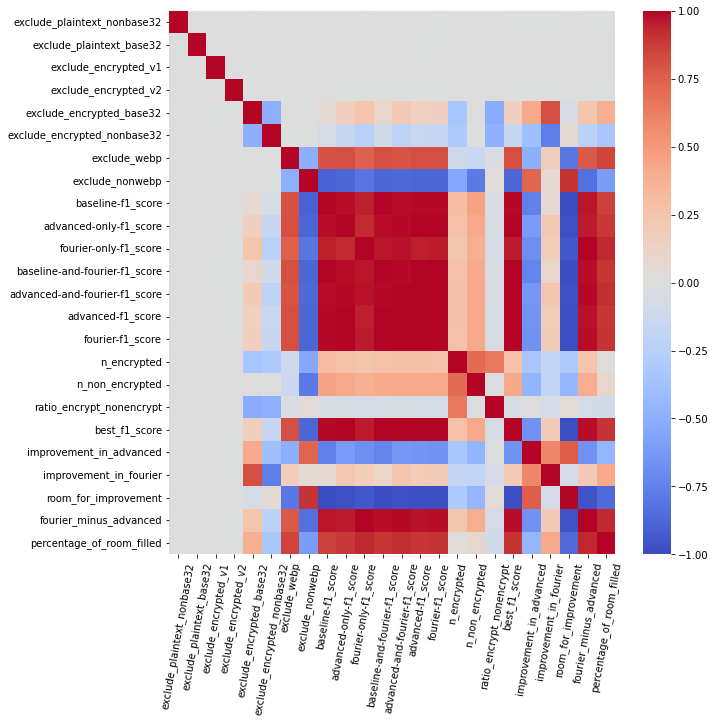

In [21]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)
df2 = df[[c for c in df.columns if \
          "precision" not in c and \
          "accuracy" not in c and \
          "recall" not in c]]
sns.heatmap(df2.astype(float).corr(), cmap='coolwarm')
# print(df[df["baseline-f1_score"] > 0.9].astype(float))
_ = plt.xticks(rotation=80) 

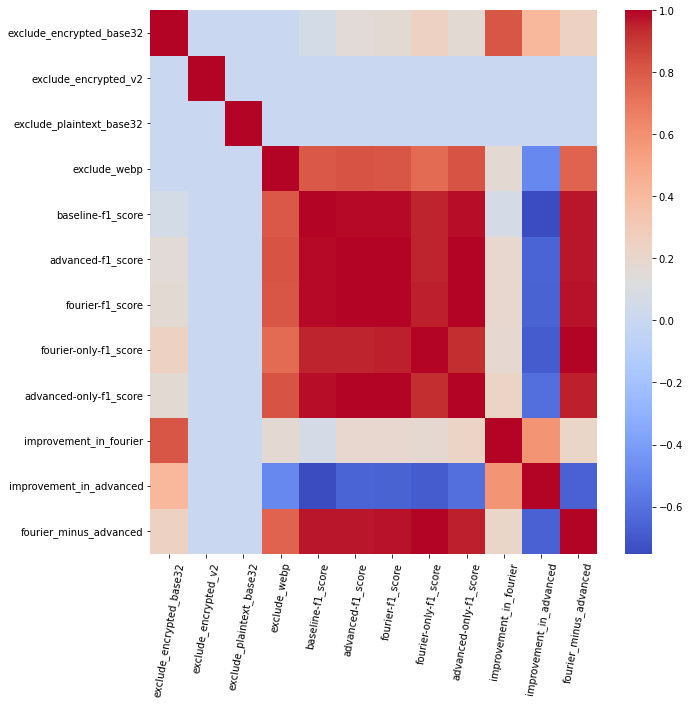

In [45]:
df1 = df[["exclude_encrypted_base32", \
          "exclude_encrypted_v2", \
          "exclude_plaintext_base32",\
          "exclude_webp", \
          "baseline-f1_score", \
          "advanced-f1_score", \
          "fourier-f1_score",
          "fourier-only-f1_score",
          "advanced-only-f1_score",
          "improvement_in_fourier",
          "improvement_in_advanced",
          "fourier_minus_advanced"
          ]]
sns.heatmap(df1.astype(float).corr(), cmap='coolwarm')
_ = plt.xticks(rotation=80) 

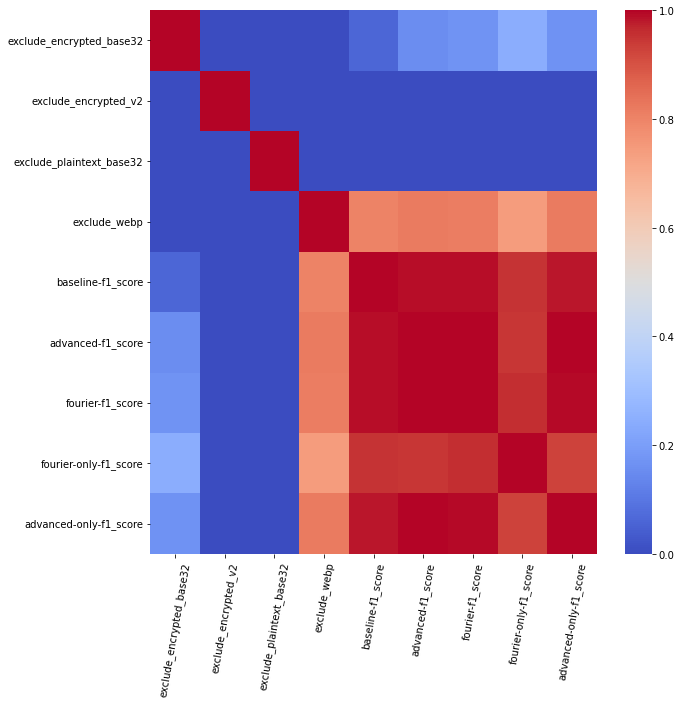

In [46]:
df1 = df[["exclude_encrypted_base32", \
          "exclude_encrypted_v2", \
          "exclude_plaintext_base32",\
          "exclude_webp", \
          "baseline-f1_score", \
          "advanced-f1_score", \
          "fourier-f1_score",
          "fourier-only-f1_score",
          "advanced-only-f1_score",
          ]]
sns.heatmap(df1.astype(float).corr(), cmap='coolwarm')
_ = plt.xticks(rotation=80) 

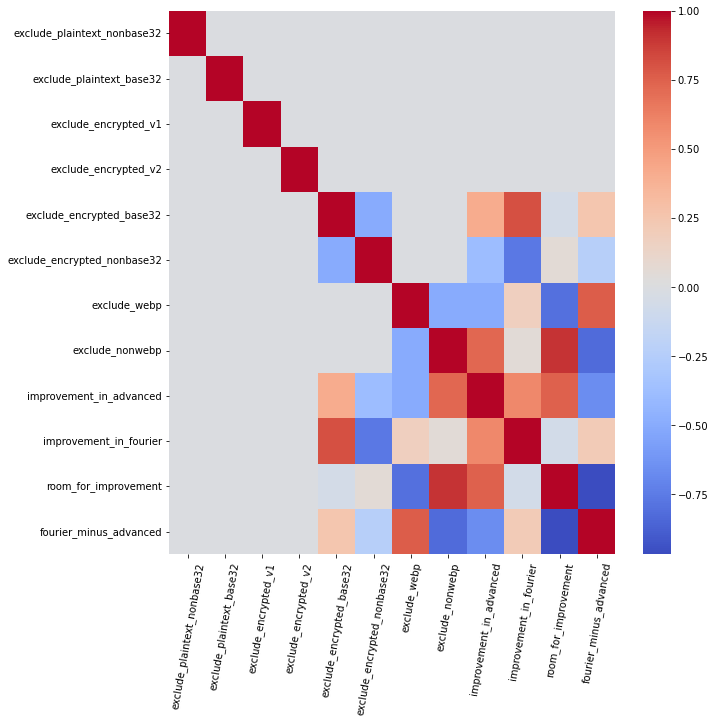

In [47]:
cols = [c for c in df.columns if "improve" in c or "minus" in c or "exclude" in c]
df1 = df[cols]
sns.heatmap(df1.astype(float).corr(), cmap='coolwarm')
_ = plt.xticks(rotation=80) 

### Average out all the metrics <a class="anchor" id="mean-fscores">

To conclude we report the average of the f1-scores and the improvements with all datasets
    
[top](#Contents)

In [23]:
df[[c for c in df.columns if ("score" in c or "improvement" in c) and "room" not in c]].mean()

baseline-f1_score                       0.869127
baseline-accuracy_score                 0.841589
baseline-precision_score                0.824341
baseline-recall_score                   0.921938
advanced-only-f1_score                  0.879295
advanced-only-accuracy_score            0.856911
advanced-only-precision_score           0.842323
advanced-only-recall_score              0.921042
fourier-only-f1_score                   0.875990
fourier-only-accuracy_score             0.840270
fourier-only-precision_score            0.794997
fourier-only-recall_score               0.980759
baseline-and-fourier-f1_score           0.900685
baseline-and-fourier-accuracy_score     0.874727
baseline-and-fourier-precision_score    0.838610
baseline-and-fourier-recall_score       0.977858
advanced-and-fourier-f1_score           0.907584
advanced-and-fourier-accuracy_score     0.889765
advanced-and-fourier-precision_score    0.872106
advanced-and-fourier-recall_score       0.947815
advanced-f1_score   

In [24]:
df[[c for c in df.columns if \
    ("-and-" in c or \
     "only" in c or \
     "score" in c or \
     "improvement" in c) and "room" not in c]].describe().T

,count,mean,std,min,25%,50%,75%,max
baseline-f1_score,144.0,0.869127,0.052331,0.796234,0.808721,0.876290,0.914332,0.942639
baseline-accuracy_score,144.0,0.841589,0.073334,0.704630,0.779458,0.859695,0.903488,0.942786
baseline-precision_score,144.0,0.824341,0.078531,0.724005,0.734006,0.824255,0.904309,0.935190
baseline-recall_score,144.0,0.921938,0.023875,0.869994,0.915908,0.933878,0.936016,0.950212
advanced-only-f1_score,144.0,0.879295,0.041773,0.816017,0.838853,0.882604,0.917602,0.937442
advanced-only-accuracy_score,144.0,0.856911,0.057360,0.750953,0.829255,0.864122,0.901558,0.937560
advanced-only-precision_score,144.0,0.842323,0.059689,0.745432,0.805409,0.837554,0.897778,0.929398
advanced-only-recall_score,144.0,0.921042,0.024537,0.875202,0.901381,0.932777,0.939845,0.945629
fourier-only-f1_score,144.0,0.875990,0.051991,0.806993,0.827043,0.880588,0.900210,0.974777
fourier-only-accuracy_score,144.0,0.840270,0.075979,0.706263,0.789360,0.838629,0.890495,0.974781


In [48]:
# Full score


def regroup(df):
    def get_name(name):
        if "score" not in name.lower():
            return None, None
        feature = name
        measure = None

        measure_map = {
            "f1_score": "F1",
            "accuracy_score": "Accuracy",
            "precision_score": "Precision",
            "recall_score": "Recall"
        }
        featurename_map = {
            "fourier-only-": "Fourier Only",
            "advanced-only-": "Advanced Only",
            "baseline-and-fourier": "Baseline and Fourier",
            "advanced-and-fourier": "Advanced and Fourier",
            "baseline-and-advanced": "Baseline and Advanced",
            "fourier-": "Baseline, Advanced and Fourier",
            "baseline-": "Baseline",
            "advanced-": "Baseline and Advanced",
        }
        for i, j in measure_map.items():
            if i in name:
                measure = j
                break
        for i, j in featurename_map.items():
            if i in name:
                feature = j
                break
        return name, feature, measure

    pd.DataFrame({"Score": df.mean()})
    indices = list(df.mean().index)
    values = df.mean().to_numpy()
    df_acc = pd.DataFrame({"Original":["dummy"], "Feature": ["dummy"], "MeasureName": ["dummy"], "MeasureValue": [0.0]})


    for name, value in zip(indices, values):
        if "score" in name.lower():
            orname, featurename, measurename = get_name(name)
            if featurename is not None:
                tempdf = pd.DataFrame({"Original": [orname], "Feature": [featurename], "MeasureName": [measurename], "MeasureValue": [value]})
                df_acc = pd.concat([df_acc, tempdf]).copy()
    df_acc = df_acc[df_acc["Feature"] != "dummy"]  
    df_acc = df_acc[df_acc["Original"] != "best_f1_score"]
    return df_acc



def regroup_and_pivot(df):
    acc_df = regroup(df)
    acc_df = acc_df[["Feature", "MeasureName", "MeasureValue"]]
    return acc_df.pivot(index="Feature", columns="MeasureName", values="MeasureValue")
    
regroup_and_pivot(df).sort_values(by="F1")

MeasureName,Accuracy,F1,Precision,Recall
Feature,,,,
Baseline,0.841589,0.869127,0.824341,0.921938
Fourier Only,0.840270,0.875990,0.794997,0.980759
Advanced Only,0.856911,0.879295,0.842323,0.921042
Baseline and Advanced,0.875433,0.895071,0.859397,0.935410
Baseline and Fourier,0.874727,0.900685,0.838610,0.977858
Advanced and Fourier,0.889765,0.907584,0.872106,0.947815
"Baseline, Advanced and Fourier",0.896079,0.913007,0.877431,0.953400


In [28]:
print(regroup_and_pivot(df).to_latex())

\begin{tabular}{lrrrr}
\toprule
MeasureName &  Accuracy &        F1 &  Precision &    Recall \\
Feature                        &           &           &            &           \\
\midrule
Advanced Only                  &  0.856911 &  0.879295 &   0.842323 &  0.921042 \\
Advanced and Fourier           &  0.889765 &  0.907584 &   0.872106 &  0.947815 \\
Baseline                       &  0.841589 &  0.869127 &   0.824341 &  0.921938 \\
Baseline and Advanced          &  0.875433 &  0.895071 &   0.859397 &  0.935410 \\
Baseline and Fourier           &  0.874727 &  0.900685 &   0.838610 &  0.977858 \\
Baseline, Advanced and Fourier &  0.896079 &  0.913007 &   0.877431 &  0.953400 \\
Fourier Only                   &  0.840270 &  0.875990 &   0.794997 &  0.980759 \\
\bottomrule
\end{tabular}



In [40]:
regroup_and_pivot(df)[['F1', 'Precision', 'Recall']].sort_values(by="F1")

MeasureName,F1,Precision,Recall
Feature,,,
Baseline,0.869127,0.824341,0.921938
Fourier Only,0.875990,0.794997,0.980759
Advanced Only,0.879295,0.842323,0.921042
Baseline and Advanced,0.895071,0.859397,0.935410
Baseline and Fourier,0.900685,0.838610,0.977858
Advanced and Fourier,0.907584,0.872106,0.947815
"Baseline, Advanced and Fourier",0.913007,0.877431,0.953400


In [30]:
print(regroup_and_pivot(df)[['F1', 'Precision', 'Recall']].to_latex())

\begin{tabular}{lrrr}
\toprule
MeasureName &        F1 &  Precision &    Recall \\
Feature                        &           &            &           \\
\midrule
Advanced Only                  &  0.879295 &   0.842323 &  0.921042 \\
Advanced and Fourier           &  0.907584 &   0.872106 &  0.947815 \\
Baseline                       &  0.869127 &   0.824341 &  0.921938 \\
Baseline and Advanced          &  0.895071 &   0.859397 &  0.935410 \\
Baseline and Fourier           &  0.900685 &   0.838610 &  0.977858 \\
Baseline, Advanced and Fourier &  0.913007 &   0.877431 &  0.953400 \\
Fourier Only                   &  0.875990 &   0.794997 &  0.980759 \\
\bottomrule
\end{tabular}



In [31]:
df1 = df[[c for c in df.columns if \
          ("score" in c or "improvement" in c) \
          and "room" not in c]]
columns = ["baseline-f1_score"]
columns += [c for c in df1.columns if "only" in c]
columns += [c for c in df1.columns if "-and-" in c]
columns += [c for c in df1.columns if "only" not in c \
            and "-and-" not in c and "baseline-f1_score" != c]
df1[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
baseline-f1_score,144.0,0.869127,0.052331,0.796234,0.808721,0.876290,0.914332,0.942639
advanced-only-f1_score,144.0,0.879295,0.041773,0.816017,0.838853,0.882604,0.917602,0.937442
advanced-only-accuracy_score,144.0,0.856911,0.057360,0.750953,0.829255,0.864122,0.901558,0.937560
advanced-only-precision_score,144.0,0.842323,0.059689,0.745432,0.805409,0.837554,0.897778,0.929398
advanced-only-recall_score,144.0,0.921042,0.024537,0.875202,0.901381,0.932777,0.939845,0.945629
fourier-only-f1_score,144.0,0.875990,0.051991,0.806993,0.827043,0.880588,0.900210,0.974777
fourier-only-accuracy_score,144.0,0.840270,0.075979,0.706263,0.789360,0.838629,0.890495,0.974781
fourier-only-precision_score,144.0,0.794997,0.084071,0.697322,0.710481,0.793698,0.826666,0.964878
fourier-only-recall_score,144.0,0.980759,0.009830,0.957607,0.978023,0.984886,0.988121,0.989367
baseline-and-fourier-f1_score,144.0,0.900685,0.059437,0.820805,0.833622,0.905171,0.947997,0.991102


In [32]:
df1[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
baseline-f1_score,144.0,0.869127,0.052331,0.796234,0.808721,0.876290,0.914332,0.942639
advanced-only-f1_score,144.0,0.879295,0.041773,0.816017,0.838853,0.882604,0.917602,0.937442
advanced-only-accuracy_score,144.0,0.856911,0.057360,0.750953,0.829255,0.864122,0.901558,0.937560
advanced-only-precision_score,144.0,0.842323,0.059689,0.745432,0.805409,0.837554,0.897778,0.929398
advanced-only-recall_score,144.0,0.921042,0.024537,0.875202,0.901381,0.932777,0.939845,0.945629
fourier-only-f1_score,144.0,0.875990,0.051991,0.806993,0.827043,0.880588,0.900210,0.974777
fourier-only-accuracy_score,144.0,0.840270,0.075979,0.706263,0.789360,0.838629,0.890495,0.974781
fourier-only-precision_score,144.0,0.794997,0.084071,0.697322,0.710481,0.793698,0.826666,0.964878
fourier-only-recall_score,144.0,0.980759,0.009830,0.957607,0.978023,0.984886,0.988121,0.989367
baseline-and-fourier-f1_score,144.0,0.900685,0.059437,0.820805,0.833622,0.905171,0.947997,0.991102


# Reporting for the final report <a class="anchor" id="report">
    
[top](#Contents)

In [33]:
def regroup(df):
    def get_name(name):
        if "score" not in name.lower():
            return None, None
        feature = name
        measure = None

        measure_map = {
            "f1_score": "F1",
            "accuracy_score": "Accuracy",
            "precision_score": "Precision",
            "recall_score": "Recall"
        }
        featurename_map = {
            "fourier-only-": "Fourier Only",
            "advanced-only-": "Advanced Only",
            "baseline-and-fourier": "Baseline and Fourier",
            "advanced-and-fourier": "Advanced and Fourier",
            "baseline-and-advanced": "Baseline and Advanced",
            "fourier-": "Baseline, Advanced and Fourier",
            "baseline-": "Baseline",
            "advanced-": "Baseline and Advanced",
        }
        for i, j in measure_map.items():
            if i in name:
                measure = j
                break
        for i, j in featurename_map.items():
            if i in name:
                feature = j
                break
        return name, feature, measure

    pd.DataFrame({"Score": df.mean()})
    indices = list(df.mean().index)
    values = df.mean().to_numpy()
    df_acc = pd.DataFrame({"Original":["dummy"], "Feature": ["dummy"], "MeasureName": ["dummy"], "MeasureValue": [0.0]})


    for name, value in zip(indices, values):
        if "score" in name.lower():
            orname, featurename, measurename = get_name(name)
            if featurename is not None:
                tempdf = pd.DataFrame({"Original": [orname], "Feature": [featurename], "MeasureName": [measurename], "MeasureValue": [value]})
                df_acc = pd.concat([df_acc, tempdf]).copy()
    df_acc = df_acc[df_acc["Feature"] != "dummy"]  
    df_acc = df_acc[df_acc["Original"] != "best_f1_score"]
    return df_acc


def regroup_and_pivot(df):
    acc_df = regroup(df)
    acc_df = acc_df[["Feature", "MeasureName", "MeasureValue"]]
    return acc_df.pivot(index="Feature", columns="MeasureName", values="MeasureValue")
    

In [34]:
df = pd.read_csv("../RF_comparison_logistic_regression_final.csv")
df2 = regroup_and_pivot(df.copy())
print(df2.to_latex())
df2

\begin{tabular}{lrrrr}
\toprule
MeasureName &  Accuracy &        F1 &  Precision &    Recall \\
Feature                        &           &           &            &           \\
\midrule
Advanced Only                  &  0.856911 &  0.879295 &   0.842323 &  0.921042 \\
Advanced and Fourier           &  0.889765 &  0.907584 &   0.872106 &  0.947815 \\
Baseline                       &  0.841589 &  0.869127 &   0.824341 &  0.921938 \\
Baseline and Advanced          &  0.875433 &  0.895071 &   0.859397 &  0.935410 \\
Baseline and Fourier           &  0.874727 &  0.900685 &   0.838610 &  0.977858 \\
Baseline, Advanced and Fourier &  0.896079 &  0.913007 &   0.877431 &  0.953400 \\
Fourier Only                   &  0.840270 &  0.875990 &   0.794997 &  0.980759 \\
\bottomrule
\end{tabular}



MeasureName,Accuracy,F1,Precision,Recall
Feature,,,,
Advanced Only,0.856911,0.879295,0.842323,0.921042
Advanced and Fourier,0.889765,0.907584,0.872106,0.947815
Baseline,0.841589,0.869127,0.824341,0.921938
Baseline and Advanced,0.875433,0.895071,0.859397,0.935410
Baseline and Fourier,0.874727,0.900685,0.838610,0.977858
"Baseline, Advanced and Fourier",0.896079,0.913007,0.877431,0.953400
Fourier Only,0.840270,0.875990,0.794997,0.980759


In [35]:
df2 = df[(df["exclude_webp"] == 0) & (df["exclude_nonwebp"] == 1) ]
df2 = regroup_and_pivot(df2.copy())
print(df2.to_latex())
df2

\begin{tabular}{lrrrr}
\toprule
MeasureName &  Accuracy &        F1 &  Precision &    Recall \\
Feature                        &           &           &            &           \\
\midrule
Advanced Only                  &  0.791105 &  0.827587 &   0.775267 &  0.888390 \\
Advanced and Fourier           &  0.808669 &  0.842223 &   0.788393 &  0.905112 \\
Baseline                       &  0.752663 &  0.802702 &   0.729049 &  0.893262 \\
Baseline and Advanced          &  0.803931 &  0.838344 &   0.784452 &  0.901256 \\
Baseline and Fourier           &  0.774823 &  0.827347 &   0.728384 &  0.957685 \\
Baseline, Advanced and Fourier &  0.814403 &  0.847128 &   0.792114 &  0.911589 \\
Fourier Only                   &  0.754345 &  0.816955 &   0.704129 &  0.972863 \\
\bottomrule
\end{tabular}



MeasureName,Accuracy,F1,Precision,Recall
Feature,,,,
Advanced Only,0.791105,0.827587,0.775267,0.888390
Advanced and Fourier,0.808669,0.842223,0.788393,0.905112
Baseline,0.752663,0.802702,0.729049,0.893262
Baseline and Advanced,0.803931,0.838344,0.784452,0.901256
Baseline and Fourier,0.774823,0.827347,0.728384,0.957685
"Baseline, Advanced and Fourier",0.814403,0.847128,0.792114,0.911589
Fourier Only,0.754345,0.816955,0.704129,0.972863


In [36]:
df2 = df[(df["exclude_webp"] == 1) & (df["exclude_nonwebp"] == 0) ]
df2 = regroup_and_pivot(df2.copy())
print(df2.to_latex())
df2

\begin{tabular}{lrrrr}
\toprule
MeasureName &  Accuracy &        F1 &  Precision &    Recall \\
Feature                        &           &           &            &           \\
\midrule
Advanced Only                  &  0.918046 &  0.927430 &   0.913521 &  0.941828 \\
Advanced and Fourier           &  0.963315 &  0.967619 &   0.957662 &  0.977898 \\
Baseline                       &  0.919635 &  0.928421 &   0.919547 &  0.937475 \\
Baseline and Advanced          &  0.940989 &  0.947623 &   0.936760 &  0.958784 \\
Baseline and Fourier           &  0.964950 &  0.969387 &   0.952097 &  0.987651 \\
Baseline, Advanced and Fourier &  0.970615 &  0.974057 &   0.964669 &  0.983726 \\
Fourier Only                   &  0.916592 &  0.930504 &   0.886024 &  0.982005 \\
\bottomrule
\end{tabular}



MeasureName,Accuracy,F1,Precision,Recall
Feature,,,,
Advanced Only,0.918046,0.927430,0.913521,0.941828
Advanced and Fourier,0.963315,0.967619,0.957662,0.977898
Baseline,0.919635,0.928421,0.919547,0.937475
Baseline and Advanced,0.940989,0.947623,0.936760,0.958784
Baseline and Fourier,0.964950,0.969387,0.952097,0.987651
"Baseline, Advanced and Fourier",0.970615,0.974057,0.964669,0.983726
Fourier Only,0.916592,0.930504,0.886024,0.982005


In [41]:
df2 = df[(df["exclude_webp"] == 0) & (df["exclude_nonwebp"] == 1) ]
df2 = df.copy()
df2 = df2[[c for c in df2.columns if "score" in c]]
df2 = df2.describe().T
df2 = df2["std"]

def get_name(name):
    if "score" not in name.lower():
        return None, None
    feature = name
    measure = None

    measure_map = {
        "f1_score": "F1",
        "accuracy_score": "Accuracy",
        "precision_score": "Precision",
        "recall_score": "Recall"
    }
    featurename_map = {
        "fourier-only-": "Fourier Only",
        "advanced-only-": "Advanced Only",
        "baseline-and-fourier": "Baseline and Fourier",
        "advanced-and-fourier": "Advanced and Fourier",
        "baseline-and-advanced": "Baseline and Advanced",
        "fourier-": "Baseline, Advanced and Fourier",
        "baseline-": "Baseline",
        "advanced-": "Baseline and Advanced",
    }
    for i, j in measure_map.items():
        if i in name:
            measure = j
            break
    for i, j in featurename_map.items():
        if i in name:
            feature = j
            break
    return name, feature, measure


indices = list(df2.index)
values = df2.to_numpy()
df_acc = pd.DataFrame({"Original":["dummy"], "Feature": ["dummy"], "MeasureName": ["dummy"], "MeasureValue": [0.0]})


for name, value in zip(indices, values):
    if "score" in name.lower():
        orname, featurename, measurename = get_name(name)
        if featurename is not None:
            tempdf = pd.DataFrame({"Original": [orname], "Feature": [featurename], "MeasureName": [measurename], "MeasureValue": [value]})
            df_acc = pd.concat([df_acc, tempdf]).copy()
df_acc = df_acc[df_acc["Feature"] != "dummy"]  
df_acc = df_acc[df_acc["Original"] != "best_f1_score"]
df_acc = df_acc[[c for c in df_acc.columns if "Original" != c]]

df_acc = df_acc.pivot(index="Feature", columns="MeasureName", values="MeasureValue")
print(df_acc.to_latex())
df_acc.sort_values(by="F1")

\begin{tabular}{lrrrr}
\toprule
MeasureName &  Accuracy &        F1 &  Precision &    Recall \\
Feature                        &           &           &            &           \\
\midrule
Advanced Only                  &  0.057360 &  0.041773 &   0.059689 &  0.024537 \\
Advanced and Fourier           &  0.068008 &  0.053480 &   0.073898 &  0.033505 \\
Baseline                       &  0.073334 &  0.052331 &   0.078531 &  0.023875 \\
Baseline and Advanced          &  0.060423 &  0.045640 &   0.065087 &  0.027016 \\
Baseline and Fourier           &  0.081819 &  0.059437 &   0.093600 &  0.017830 \\
Baseline, Advanced and Fourier &  0.067696 &  0.053282 &   0.074139 &  0.033096 \\
Fourier Only                   &  0.075979 &  0.051991 &   0.084071 &  0.009830 \\
\bottomrule
\end{tabular}



MeasureName,Accuracy,F1,Precision,Recall
Feature,,,,
Advanced Only,0.057360,0.041773,0.059689,0.024537
Baseline and Advanced,0.060423,0.045640,0.065087,0.027016
Fourier Only,0.075979,0.051991,0.084071,0.009830
Baseline,0.073334,0.052331,0.078531,0.023875
"Baseline, Advanced and Fourier",0.067696,0.053282,0.074139,0.033096
Advanced and Fourier,0.068008,0.053480,0.073898,0.033505
Baseline and Fourier,0.081819,0.059437,0.093600,0.017830


In [38]:
df2 = df[(df["exclude_webp"] == 0) & (df["exclude_nonwebp"] == 1) ]
#df2 = df.copy()
df2 = df2[[c for c in df2.columns if "score" in c]]
df2 = df2.describe().T
df2 = df2["std"]

def get_name(name):
    if "score" not in name.lower():
        return None, None
    feature = name
    measure = None

    measure_map = {
        "f1_score": "F1",
        "accuracy_score": "Accuracy",
        "precision_score": "Precision",
        "recall_score": "Recall"
    }
    featurename_map = {
        "fourier-only-": "Fourier Only",
        "advanced-only-": "Advanced Only",
        "baseline-and-fourier": "Baseline and Fourier",
        "advanced-and-fourier": "Advanced and Fourier",
        "baseline-and-advanced": "Baseline and Advanced",
        "fourier-": "Baseline, Advanced and Fourier",
        "baseline-": "Baseline",
        "advanced-": "Baseline and Advanced",
    }
    for i, j in measure_map.items():
        if i in name:
            measure = j
            break
    for i, j in featurename_map.items():
        if i in name:
            feature = j
            break
    return name, feature, measure


indices = list(df2.index)
values = df2.to_numpy()
df_acc = pd.DataFrame({"Original":["dummy"], "Feature": ["dummy"], "MeasureName": ["dummy"], "MeasureValue": [0.0]})


for name, value in zip(indices, values):
    if "score" in name.lower():
        orname, featurename, measurename = get_name(name)
        if featurename is not None:
            tempdf = pd.DataFrame({"Original": [orname], "Feature": [featurename], "MeasureName": [measurename], "MeasureValue": [value]})
            df_acc = pd.concat([df_acc, tempdf]).copy()
df_acc = df_acc[df_acc["Feature"] != "dummy"]  
df_acc = df_acc[df_acc["Original"] != "best_f1_score"]
df_acc = df_acc[[c for c in df_acc.columns if "Original" != c]]

df_acc = df_acc.pivot(index="Feature", columns="MeasureName", values="MeasureValue")
print(df_acc.to_latex())
df_acc

\begin{tabular}{lrrrr}
\toprule
MeasureName &  Accuracy &        F1 &  Precision &    Recall \\
Feature                        &           &           &            &           \\
\midrule
Advanced Only                  &  0.032336 &  0.009424 &   0.024746 &  0.010802 \\
Advanced and Fourier           &  0.028825 &  0.006137 &   0.023936 &  0.017348 \\
Baseline                       &  0.034400 &  0.005162 &   0.004127 &  0.018948 \\
Baseline and Advanced          &  0.029118 &  0.005135 &   0.022127 &  0.017316 \\
Baseline and Fourier           &  0.031713 &  0.005291 &   0.002154 &  0.017846 \\
Baseline, Advanced and Fourier &  0.027571 &  0.004583 &   0.022931 &  0.019787 \\
Fourier Only                   &  0.035532 &  0.008273 &   0.005439 &  0.013134 \\
\bottomrule
\end{tabular}



MeasureName,Accuracy,F1,Precision,Recall
Feature,,,,
Advanced Only,0.032336,0.009424,0.024746,0.010802
Advanced and Fourier,0.028825,0.006137,0.023936,0.017348
Baseline,0.034400,0.005162,0.004127,0.018948
Baseline and Advanced,0.029118,0.005135,0.022127,0.017316
Baseline and Fourier,0.031713,0.005291,0.002154,0.017846
"Baseline, Advanced and Fourier",0.027571,0.004583,0.022931,0.019787
Fourier Only,0.035532,0.008273,0.005439,0.013134


In [39]:
df.to_csv("RF_SAMPLED_CS5_FINAL.csv")